# Dataset Description
Analysis of Telegram channel and post data: engagement, media, temporal patterns.

## 1. Imports & Plot Configuration

In [7]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator, ScalarFormatter
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm
from engineering_notation import EngNumber
if 'notebooks' in os.listdir('../'):
    os.chdir('../')

In [2]:
# Plot configuration for academic publication layout
rcParams = {'font.size': 6.5, 'font.family': "serif"}
plt.rcParams.update(rcParams)

column_width = 3.32492194445
sep_width    = 0.3764061111113
page_width   = 2 * column_width + sep_width

---
## 2. Load & Prepare Channel Data

In [8]:
# Load TGStat scraped channel lists and tag by type
news_tgstat = pd.read_excel("../data/TGstat_results_news.xlsx")
news_tgstat['channel_type'] = 'news'

politics_tgstat = pd.read_excel("../data/TGstat_results_politics.xlsx")
politics_tgstat['channel_type'] = 'politics'

merged_channels = pd.concat([news_tgstat, politics_tgstat])

print(f"{len(news_tgstat)} news channels")
print(f"{len(politics_tgstat)} politics channels")
print(f"{len(merged_channels)} all channels")
print(f"{len(merged_channels.handle.unique())} unique handles")

1566 news channels
401 politics channels
1967 all channels
1967 unique handles


In [9]:
# Filter to channels with >= 500 subscribers
print(f"{len(merged_channels[merged_channels.n_sub < 500])} channels excluded (< 500 subs)")
merged_channels500 = merged_channels[merged_channels.n_sub >= 500]
merged_channels500.groupby('channel_type').count()

225 channels excluded (< 500 subs)


,name,handle,description,n_sub,exclude
channel_type,,,,,
news,1396,1396,1288,1396,0
politics,346,346,322,346,346


In [10]:
# Load recommended channels (filtered to non-excluded)
recommanded_channels = pd.read_excel('../data/recommended_files.xlsx')
recommanded_channels = recommanded_channels[recommanded_channels.Exclude == 0]

In [12]:
# Load full channel metadata from JSON (includes Telegram API fields)
reco_channels_info   = pd.read_json('../data/Telegram_data/metadata/recommended_channels.json')
TGstat_channels_info = pd.read_json('../data/Telegram_data/metadata/TGstat_channels.json')
channels_df          = pd.read_json('../data/Telegram_data/metadata/channels_final_dataset.json')

print(f"{len(reco_channels_info)} recommended channels")
print(f"{len(channels_df)} channels in final dataset")

594 recommended channels
2190 channels in final dataset


---
## 3. Load & Prepare Post Data

In [13]:
# Load merged post JSON (output of Clean_dataset pipeline)
with open("../data/Telegram_data/all_posts.json") as f:
    all_posts = json.load(f)

print(f"{len(all_posts)} channels with posts")

2190 channels with posts


In [14]:
# Flatten all posts into a DataFrame for analysis.
# Normalise document_id / photo_id → media_id.
columns = [
    'id', 'uid', 'sender_id', 'date', 'text',
    'views', 'forwards', 'reactions', 'comments',
    'origin_from_id', 'origin_channel_post',
    'media_id', 'media_type', 'size'
]
rows = []

for channel, posts in tqdm(all_posts.items()):
    for post in posts:
        if 'document_id' in post:
            post['media_id'] = post['document_id']
        if 'photo_id' in post:
            post['media_id'] = post['photo_id']
        rows.append({col: post.get(col) for col in columns})

posts_df = pd.DataFrame(rows)
del posts

print(f"{len(posts_df):,} total posts")

  0%|          | 0/2190 [00:00<?, ?it/s]

3,653,769 total posts


In [15]:
# Cast integer columns, treating blank / NaN strings as None
int_cols = ['id', 'views', 'forwards', 'size']
for col in tqdm(int_cols):
    posts_df[col] = posts_df[col].replace(('', 'Nan', 'nan', np.nan), None)
    posts_df[col] = posts_df[col].apply(lambda x: int(x) if x else None)

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
# Derived column: True when the post contains any media
posts_df["has_media"] = posts_df["media_id"].notna() | posts_df["media_type"].notna()

print(f"{100 * posts_df['has_media'].mean():.2f}% of posts contain media")

63.94% of posts contain media


---
## 4. Media Inventory — Item Counts & Total Size (Deduplicated)

In [17]:
# Raw total (includes duplicates where the same media was re-uploaded)
total_size = posts_df['size'].dropna().sum() / 1e12
print(f"Total size of all media (with duplicates): {total_size:.1f} TB")

Total size of all media (with duplicates): 7.1 TB


In [18]:
# Deduplicated totals per media type.
# A channel can repost a video without forwarding it, creating a new media_id
# for the same underlying file — we collapse by media_id to avoid double-counting.
media_type_groups = [
    ['photo'],
    ['video'],
    ['document', 'MessageMediaPoll', 'MessageMediaWebPage',
     'MessageMediaGiveawayResults', 'MessageMediaGiveaway',
     'MessageMediaStory', 'MessageMediaGeo', 'MessageMediaPaidMedia'],
]

for media_type in media_type_groups:
    print(media_type)
    curr_post_df = posts_df[posts_df.media_type.isin(media_type)]
    print(f"  {curr_post_df['media_id'].nunique():,} unique media_ids")

    grouped = curr_post_df.groupby('media_id')['size'].unique().reset_index()
    grouped['n_diff_sizes'] = grouped['size'].apply(len)
    assert (grouped['n_diff_sizes'] == 1).all(), "media_id maps to multiple sizes!"

    total = sum(int(s[0]) for s in grouped['size'].values)
    print(f"  total size (deduplicated): {total:,} bytes ({total/1e9:.1f} GB)")

['photo']
  894,123 unique media_ids
  total size (deduplicated): 112,543,958,245 bytes (112.5 GB)
['video']
  399,492 unique media_ids
  total size (deduplicated): 3,683,365,436,881 bytes (3683.4 GB)
['document', 'MessageMediaPoll', 'MessageMediaWebPage', 'MessageMediaGiveawayResults', 'MessageMediaGiveaway', 'MessageMediaStory', 'MessageMediaGeo', 'MessageMediaPaidMedia']
  14,718 unique media_ids
  total size (deduplicated): 167,707,872,089 bytes (167.7 GB)


---
## 5. Engagement Distribution (CCDF Plots)

In [19]:
def get_n_reactions(reactions):
    """Sum reaction counts across all emoji types. Returns None if reactions is not a list."""
    try:
        if len(reactions) > 0:
            return sum(int(r['count']) for r in reactions)
        return 0
    except TypeError:
        return None

posts_df['n_reaction'] = posts_df['reactions'].apply(get_n_reactions)
engagement_df = posts_df[['views', 'forwards', 'n_reaction']]

In [20]:
def plot_CCDF(df, col, ax, title):
    """Plot a log-log CCDF with median and 95th-percentile markers."""
    values = df[col].dropna().values
    values = values[values > 0]
    values_sorted = np.sort(values)
    n = len(values_sorted)
    if n == 0:
        return

    ax.set_xscale("log")
    ax.set_yscale("log")

    ccdf = np.arange(n, 0, -1) / n
    ax.plot(values_sorted, ccdf, 'k', linewidth=1)

    q50 = np.quantile(values_sorted, 0.5)
    q95 = np.quantile(values_sorted, 0.95)

    def ccdf_at(x):
        k = np.searchsorted(values_sorted, x, side="left")
        return (n - k) / n

    y50 = ccdf_at(q50)
    y95 = ccdf_at(q95)

    ax.xaxis.set_major_locator(mticker.LogLocator(base=10))
    ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.minorticks_on()
    ax.tick_params(axis="x", which="major", bottom=True)
    ax.tick_params(axis="x", which="minor", bottom=True)

    txt = ax.text(0.02, 0.5, "median",
                  transform=ax.get_yaxis_transform(),
                  va='bottom', ha='left', color='k')
    txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='w')])
    ax.text(0.02, 0.05, "0.95-quantile",
            transform=ax.get_yaxis_transform(),
            va='bottom', ha='left', color='k')

    x_left, x_right = ax.get_xlim()
    y_bottom, y_top  = ax.get_ylim()

    ax.vlines(q50, y_bottom, y50, color="red", linestyle=":",  linewidth=1)
    ax.hlines(y50, x_left,  q50, color="red", linestyle=":",  linewidth=1)
    ax.vlines(q95, y_bottom, y95, color="red", linestyle="--", linewidth=1)
    ax.hlines(y95, x_left,  q95, color="red", linestyle="--", linewidth=1)

    ax.set_title(title, loc='left', pad=1)

    ax.text(q50, 0.02, EngNumber(q50), rotation=90,
            transform=ax.get_xaxis_transform(),
            va='bottom', ha='right', color='k')
    ax.text(q95, 0.02, EngNumber(q95), rotation=90,
            transform=ax.get_xaxis_transform(),
            va='bottom', ha='right', color='k')

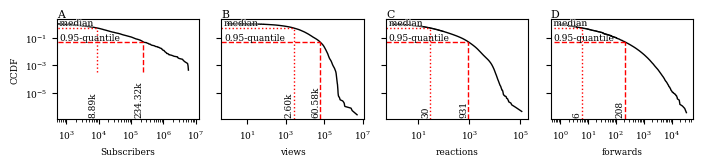

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(page_width, 0.5 * column_width), sharey=True)

plot_CCDF(channels_df,   'subscribers', axes[0], 'A')
axes[0].set_xlim(500, axes[0].get_xlim()[1])
axes[0].set_xlabel("Subscribers")
axes[0].set_ylabel("CCDF")

plot_CCDF(engagement_df, 'views',      axes[1], 'B')
axes[1].set_xlabel("views")

plot_CCDF(engagement_df, 'n_reaction', axes[2], 'C')
axes[2].set_xlabel("reactions")
axes[2].tick_params(axis="x", which="both", labelbottom=True)

plot_CCDF(engagement_df, 'forwards',   axes[3], 'D')
axes[3].set_xlabel("forwards")

plt.tight_layout()
fig.savefig('../Figures/engagement_CCDF.pdf', bbox_inches='tight')

---
## 6. Comments

In [22]:
posts_df['comment_len'] = posts_df['comments'].apply(len)

n_with_comments = len(posts_df[posts_df.comment_len > 0])
print(f"{n_with_comments:,} posts have at least one comment")
print(f"{100 * n_with_comments / len(posts_df):.2f}% of all posts")

258,909 posts have at least one comment
7.09% of all posts


---
## 7. Daily Uploads & Media Volume

In [23]:
# Key event dates (MM-DD)
war_begin               = '06-13'
internet_shutdown_begins = '06-17'
war_ends                = '06-24'

In [28]:
posts_grpby_day = (
    posts_df
    .groupby("upload_day")
    .agg(upload=("id", "count"), volume=("size", "sum"))
    .sort_index()
    # ← do NOT reset_index() here; keep upload_day as the index
)
posts_grpby_day['volume'] = posts_grpby_day['volume'] / 1e9

daily_media_pct = (
    posts_df
    .groupby("upload_day")["has_media"]
    .mean()
    .mul(100)
    .rename("pct_posts_with_media")
    # ← same: keep upload_day as the index
)

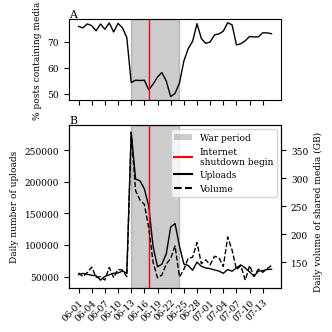

In [29]:
i0  = posts_grpby_day.index.get_loc(war_begin)
i1  = posts_grpby_day.index.get_loc(war_ends)
isd = posts_grpby_day.index.get_loc(internet_shutdown_begins)

fig, axes = plt.subplots(2, 1,
                         figsize=(column_width, column_width),
                         sharex=True,
                         gridspec_kw={'height_ratios': [1, 2]})

# — Panel A: % posts with media —
ax = axes[0]
ax.plot(daily_media_pct.values, 'k', linewidth=1)   # plot values against integer positions
ax.axvspan(i0, i1, alpha=0.2, color='k')
ax.axvline(isd, color="red", linestyle="-", linewidth=1)
ax.set_ylabel("% posts containing media")
ax.set_title("A", loc='left', pad=1)

# — Panel B: daily upload count + volume —
ax = axes[1]
ax.plot(posts_grpby_day['upload'].values, 'k-', linewidth=1)
ax.axvspan(i0, i1, alpha=0.2, color='k')
ax.axvline(isd, color="red", linestyle="-", linewidth=1)

# Use every 3rd date label on the x-axis
ticks = range(0, len(posts_grpby_day), 3)
ax.set_xticks(list(ticks))
ax.set_xticklabels([posts_grpby_day.index[i] for i in ticks],
                   rotation=45, ha="right", rotation_mode="anchor")

ax2 = ax.twinx()
ax2.plot(posts_grpby_day['volume'].values, 'k--', linewidth=1)

legend_handles = [
    Patch(facecolor="k", alpha=0.2, label="War period"),
    Line2D([0], [0], color="red", linestyle="-",  label="Internet\nshutdown begin"),
    Line2D([0], [0], color="k",   linestyle="-",  label="Uploads"),
    Line2D([0], [0], color="k",   linestyle="--", label="Volume"),
]
ax.legend(handles=legend_handles)
ax.set_ylabel('Daily number of uploads')
ax2.set_ylabel('Daily volume of shared media (GB)   ')
ax.set_title("B", loc='left', pad=1)

plt.tight_layout()
fig.savefig('../Figures/daily_upload_volume.pdf', bbox_inches='tight')

In [33]:
posts_grpby_day.reset_index(inplace=True)

# Compare pre-war vs post-war average daily uploads
pre_war_mean  = np.mean(posts_grpby_day[posts_grpby_day.upload_day <  war_begin]['upload'])
post_war_mean = np.mean(posts_grpby_day[posts_grpby_day.upload_day >= war_ends ]['upload'])
war_day_ratio = posts_grpby_day[posts_grpby_day.upload_day == war_begin]['upload'] / pre_war_mean

print(f"Pre-war mean uploads/day:  {pre_war_mean:,.0f}")
print(f"Post-war mean uploads/day: {post_war_mean:,.0f}")
print(f"{100 * (post_war_mean - pre_war_mean) / pre_war_mean:.2f}% increase post-war vs pre-war")
print(f"War start day ({war_begin}): {float(war_day_ratio.values[0]):.2f}× pre-war average")

Pre-war mean uploads/day:  53,188
Post-war mean uploads/day: 63,658
19.68% increase post-war vs pre-war
War start day (06-13): 5.23× pre-war average


---
## 8. Time-of-Day Posting Patterns

In [34]:
# Convert dates to Iran time and extract hour / weekday
posts_df["date"] = pd.to_datetime(posts_df["date"], errors="coerce")
posts_df = posts_df.dropna(subset=["date"])

posts_df["date_iran"] = posts_df["date"].dt.tz_convert("Asia/Tehran")
posts_df["weekday"]   = posts_df["date_iran"].dt.weekday   # 0 = Monday
posts_df["hour"]      = posts_df["date_iran"].dt.hour

In [35]:
# Split posts into before / during / after the war
before_war_posts = posts_df[posts_df["date"] <  "2025-06-13"]
in_war_posts     = posts_df[(posts_df["date"] >= "2025-06-13") & (posts_df["date"] < "2025-06-24")]
after_war_posts  = posts_df[posts_df["date"] >= "2025-06-24"]

print(f"Before war: {len(before_war_posts):,} posts")
print(f"During war: {len(in_war_posts):,} posts")
print(f"After war:  {len(after_war_posts):,} posts")

Before war: 638,254 posts
During war: 1,615,044 posts
After war:  1,400,471 posts


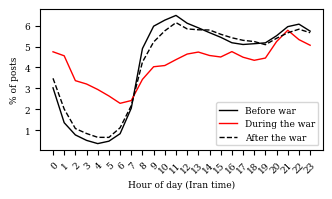

In [36]:
def hourly_pct(df):
    """Return hourly post-count distribution as percentage of that subset's total."""
    counts = df.groupby("hour").size().rename("n_posts").reset_index()
    counts["pct_posts"] = counts["n_posts"] / counts["n_posts"].sum() * 100
    return counts

before_hc = hourly_pct(before_war_posts)
in_hc     = hourly_pct(in_war_posts)
after_hc  = hourly_pct(after_war_posts)

fig, ax = plt.subplots(figsize=(column_width, 0.6 * column_width))

ax.plot(before_hc["hour"], before_hc["pct_posts"], 'k',    linewidth=1, label='Before war')
ax.plot(in_hc["hour"],     in_hc["pct_posts"],     'red',  linewidth=1, label='During the war')
ax.plot(after_hc["hour"],  after_hc["pct_posts"],  'k--',  linewidth=1, label='After the war')

ax.set_xlabel("Hour of day (Iran time)")
ax.set_ylabel("% of posts")
ax.set_xticks(range(0, 24))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.legend()

plt.tight_layout()
fig.savefig("../Figures/hour_upload.pdf", bbox_inches='tight')